In [1554]:
import pandas as pd
import numpy as np
import torch
import sklearn

cuda_available = torch.cuda.is_available()

In [1671]:
season2018 = pd.read_csv("Season2018.csv")
season2019 = pd.read_csv("Season2019.csv")
season2020 = pd.read_csv("Season2020.csv")

In [1672]:
np.random.seed(42)
season2018_test = np.random.permutation(season2018["fixture_id"])[:48]
season2019_test = np.random.permutation(season2019["fixture_id"])[:48]
season2020_test = np.random.permutation(season2020["fixture_id"])[:48]

In [1673]:
test_fixtures = np.append(np.append(season2018_test, season2019_test), season2020_test)

In [1674]:
df = pd.read_csv("SaudiLeague.csv")

In [1675]:
df.head()

,fixture_id,team,formation,coach,players,isHome,rating,opponent,opponent_formation,opponent_coach,...,opponent_last_against_performance,pts_difference,pts_after,opponent_pts_after,top_scorrer,main_gk,main_captain,opponent_top_scorrer,opponent_main_gk,opponent_main_captain
0,151695,Al-Ettifaq,4-2-3-1,L. Ramos,"R. M'Bolhi, 'R. Arias', 'Hussein Al Sayed', 'S...",1,7.00,Al-Raed,4-2-3-1,B. Hasi,...,6.72,0,1,1,1,1,0,1,0,0
1,151695,Al-Raed,4-2-3-1,B. Hasi,"'A. Doukha', 'H. Belkaroui', 'Mohammed Al Amri...",0,6.98,Al-Ettifaq,4-2-3-1,L. Ramos,...,6.90,0,1,1,1,0,0,1,1,0
2,151696,Al-Hazm,4-2-3-1,D. Isăilă,"'M. Asselah', 'Alemão', 'Khaled Al Barakah', '...",1,6.97,Al Wehda Club,4-4-2,Fábio Carille,...,7.02,0,1,1,0,0,0,1,0,0
3,151696,Al Wehda Club,4-4-2,Fábio Carille,"'Mohamed Awad', 'Osama Hawsawi', 'Renato Chave...",0,6.77,Al-Hazm,4-2-3-1,D. Isăilă,...,6.81,0,1,1,1,0,0,0,0,0
4,151697,Ohod,4-2-3-1,F. Arce,"'Z. Laaroubi', 'Hussein Abdul Ghani', 'Apodi',...",1,6.64,Al-Nassr,4-2-3-1,D. Carreño,...,7.07,0,0,3,1,0,0,0,0,0


In [1676]:
df.columns

Index(['fixture_id', 'team', 'formation', 'coach', 'players', 'isHome',
       'rating', 'opponent', 'opponent_formation', 'opponent_coach',
       'opponent_players', 'opponent_rating', 'season', 'date', 'venue',
       'status', 'round', 'team_goals', 'opponent_goals', 'pts',
       'opponent_pts', 'result', 'last_performance',
       'opponent_last_performance', 'last_against_performance',
       'opponent_last_against_performance', 'pts_difference', 'pts_after',
       'opponent_pts_after', 'top_scorrer', 'main_gk', 'main_captain',
       'opponent_top_scorrer', 'opponent_main_gk', 'opponent_main_captain'],
      dtype='object')

Let's perform all preprocessing steps then export the data into seperate CSVs

* What actions do we want to make on the data before modeling?
    1. Drop unnecessary columns 
    2. Scale numeric variables 
    3. Create dummy variables for categorical variables

##### 1.  dropping columns (columns that are not significant or can not be collected before the match)

In [1677]:
df.columns

Index(['fixture_id', 'team', 'formation', 'coach', 'players', 'isHome',
       'rating', 'opponent', 'opponent_formation', 'opponent_coach',
       'opponent_players', 'opponent_rating', 'season', 'date', 'venue',
       'status', 'round', 'team_goals', 'opponent_goals', 'pts',
       'opponent_pts', 'result', 'last_performance',
       'opponent_last_performance', 'last_against_performance',
       'opponent_last_against_performance', 'pts_difference', 'pts_after',
       'opponent_pts_after', 'top_scorrer', 'main_gk', 'main_captain',
       'opponent_top_scorrer', 'opponent_main_gk', 'opponent_main_captain'],
      dtype='object')

In [1678]:
df.drop(columns=["players", "rating", "opponent_players", "opponent_rating", "date", "venue",
                'status', "result", "pts_after","opponent_pts_after", "formation", "opponent_formation"], inplace=True)

In [1679]:
df.columns

Index(['fixture_id', 'team', 'coach', 'isHome', 'opponent', 'opponent_coach',
       'season', 'round', 'team_goals', 'opponent_goals', 'pts',
       'opponent_pts', 'last_performance', 'opponent_last_performance',
       'last_against_performance', 'opponent_last_against_performance',
       'pts_difference', 'top_scorrer', 'main_gk', 'main_captain',
       'opponent_top_scorrer', 'opponent_main_gk', 'opponent_main_captain'],
      dtype='object')

##### 2. Numeric variables scaling (based on metrics from the training data)

In [1680]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
target_scaler = preprocessing.MinMaxScaler()

#####  let's define the training data to use it for fitting the scaler 

In [1681]:
train_data = df.loc[~df["fixture_id"].isin(test_fixtures)]

In [1682]:
train_data.shape

(1152, 23)

In [1683]:
scaler.fit(train_data[["round", "pts", "opponent_pts",
                       "last_performance","opponent_last_performance",
                       'last_against_performance', 'opponent_last_against_performance','pts_difference']])

MinMaxScaler()

In [1684]:
df[["round", "pts", "opponent_pts", "last_performance",
            "opponent_last_performance",'last_against_performance', 'opponent_last_against_performance',
            'pts_difference']] = scaler.transform(df[["round", "pts", "opponent_pts",
                                                      "last_performance","opponent_last_performance",
                                                      'last_against_performance', 'opponent_last_against_performance',
                                                    'pts_difference']])

In [1685]:
df.head()

,fixture_id,team,coach,isHome,opponent,opponent_coach,season,round,team_goals,opponent_goals,...,opponent_last_performance,last_against_performance,opponent_last_against_performance,pts_difference,top_scorrer,main_gk,main_captain,opponent_top_scorrer,opponent_main_gk,opponent_main_captain
0,151695,Al-Ettifaq,L. Ramos,1,Al-Raed,B. Hasi,2018/2019,0.0,1.0,1.0,...,0.558140,0.610465,0.505814,0.5,1,1,0,1,0,0
1,151695,Al-Raed,B. Hasi,0,Al-Ettifaq,L. Ramos,2018/2019,0.0,1.0,1.0,...,0.517442,0.505814,0.610465,0.5,1,0,0,1,1,0
2,151696,Al-Hazm,D. Isăilă,1,Al Wehda Club,Fábio Carille,2018/2019,0.0,0.0,0.0,...,0.587209,0.558140,0.680233,0.5,0,0,0,1,0,0
3,151696,Al Wehda Club,Fábio Carille,0,Al-Hazm,D. Isăilă,2018/2019,0.0,0.0,0.0,...,0.563953,0.680233,0.558140,0.5,1,0,0,0,0,0
4,151697,Ohod,F. Arce,1,Al-Nassr,D. Carreño,2018/2019,0.0,1.0,2.0,...,0.674419,0.389535,0.709302,0.5,1,0,0,0,0,0


In [1686]:
type(train_data.team_goals)

pandas.core.series.Series

##### 3. dummy variables

In [1687]:
df.columns

Index(['fixture_id', 'team', 'coach', 'isHome', 'opponent', 'opponent_coach',
       'season', 'round', 'team_goals', 'opponent_goals', 'pts',
       'opponent_pts', 'last_performance', 'opponent_last_performance',
       'last_against_performance', 'opponent_last_against_performance',
       'pts_difference', 'top_scorrer', 'main_gk', 'main_captain',
       'opponent_top_scorrer', 'opponent_main_gk', 'opponent_main_captain'],
      dtype='object')

In [1688]:
df.shape

(1440, 23)

In [1689]:
dummy = pd.get_dummies(df[['team', "coach", "opponent",
                            "opponent_coach","season"]])

In [1690]:
dummy

,team_Abha,team_Al Baten,team_Al Shabab,team_Al Taawon,team_Al Wehda Club,team_Al-Adalah,team_Al-Ahli Jeddah,team_Al-Ain,team_Al-Ettifaq,team_Al-Faisaly FC,...,opponent_coach_V. Milojević,opponent_coach_Vítor Campelos,opponent_coach_Y. Al Mannai,opponent_coach_Y. Ferrera,opponent_coach_Yousef Alghadeer,opponent_coach_Youssef Anbar,opponent_coach_Z. Mamić,season_2018/2019,season_2019/2020,season_2020/2021
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1437,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [1691]:
df = pd.concat([df, dummy], axis=1)

In [1692]:
df.drop(columns=['team', "coach", "opponent", "opponent_coach","season"], inplace=True)

In [1693]:
df.shape

(1440, 225)

In [1694]:
train_data = df.loc[~df["fixture_id"].isin(test_fixtures)]
test_data =  df.loc[df["fixture_id"].isin(test_fixtures)]

In [1695]:
target_scaler.fit(train_data[["team_goals"]])

# transform target variables
train_data[["team_goals"]] = target_scaler.transform(train_data[["team_goals"]])
test_data[["team_goals"]] = target_scaler.transform(test_data[["team_goals"]])


/Users/yazeed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yazeed/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/yazeed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [1697]:
train_data.to_csv("train.csv", index=False)
test_data.to_csv("test.csv", index=False)

In [1698]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

We have to write custom Dataset class so that pytorch's Dataloader can accpet it

In [1699]:
df.columns[:20]

Index(['fixture_id', 'isHome', 'round', 'team_goals', 'opponent_goals', 'pts',
       'opponent_pts', 'last_performance', 'opponent_last_performance',
       'last_against_performance', 'opponent_last_against_performance',
       'pts_difference', 'top_scorrer', 'main_gk', 'main_captain',
       'opponent_top_scorrer', 'opponent_main_gk', 'opponent_main_captain',
       'team_Abha', 'team_Al Baten'],
      dtype='object')

In [1700]:
train_data.columns

Index(['fixture_id', 'isHome', 'round', 'team_goals', 'opponent_goals', 'pts',
       'opponent_pts', 'last_performance', 'opponent_last_performance',
       'last_against_performance',
       ...
       'opponent_coach_V. Milojević', 'opponent_coach_Vítor Campelos',
       'opponent_coach_Y. Al Mannai', 'opponent_coach_Y. Ferrera',
       'opponent_coach_Yousef Alghadeer', 'opponent_coach_Youssef Anbar',
       'opponent_coach_Z. Mamić', 'season_2018/2019', 'season_2019/2020',
       'season_2020/2021'],
      dtype='object', length=225)

In [1701]:
from torch.utils.data import  Dataset
class SaudiLeagueDataset(torch.utils.data.Dataset):
    
    def __init__(self, file_path):
        
        self.data = pd.read_csv(file_path)
        self.data.drop(columns=["fixture_id", "opponent_goals"], inplace=True)
#         self.data.drop(np.where(self.data['team_goals']>3)[0], inplace=True)
        self.data.reset_index(inplace=True, drop=True)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        
        outcome = self.data.loc[index, ["team_goals"]].values.astype(np.float32)

        match = self.data.drop(columns=["team_goals"]).iloc[index].values.astype(np.float32)

            
        return match, outcome

In [1702]:
train_dataset = SaudiLeagueDataset("train.csv")
test_dataset = SaudiLeagueDataset("test.csv")

In [1703]:
train_dataset[0]

(array([1.        , 0.        , 0.        , 0.        , 0.51744187,
        0.55813956, 0.6104651 , 0.50581396, 0.5       , 1.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

### perfect!

In [1704]:
len(train_dataset)

1152

In [1705]:
len(test_dataset)

288

In [1706]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

train_size = 1064
indices = list(range(train_size))
np.random.shuffle(indices)

split = int(np.floor(train_size * 0.15)) #get 15% of the training data
train_idx, valid_idx = indices[split:], indices[:split]

batch_size = 32

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

loaders = {'train':DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=0),
                   'valid': DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=0),
                   'test': DataLoader(test_dataset, batch_size=batch_size, 
                                          num_workers=0, shuffle=True, pin_memory=True)}

In [1707]:
for match, outcome in loaders["valid"]:
    print(match)
    print(outcome)
    break

tensor([[0.0000, 0.6207, 0.3188,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.4828, 0.3478,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.2759, 0.2754,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.6897, 0.3913,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.7241, 0.6667,  ..., 1.0000, 0.0000, 0.0000],
        [1.0000, 0.3448, 0.2029,  ..., 0.0000, 1.0000, 0.0000]])
tensor([[0.2857],
        [0.1429],
        [0.2857],
        [0.1429],
        [0.1429],
        [0.0000],
        [0.2857],
        [0.1429],
        [0.2857],
        [0.1429],
        [0.2857],
        [0.0000],
        [0.1429],
        [0.4286],
        [0.1429],
        [0.1429],
        [0.0000],
        [0.4286],
        [0.1429],
        [0.2857],
        [0.0000],
        [0.0000],
        [0.4286],
        [0.0000],
        [0.0000],
        [0.2857],
        [0.4286],
        [0.0000],
        [0.0000],
        [0.1429],
        [0.1429],
        [0.2857]])


In [1708]:
train_dataset[0][0].shape

(222,)

In [1959]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(222, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
#         self.fc5 = nn.Linear(16, 8)
#         self.fc6 = nn.Linear(8, 1)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
#         x = F.relu(self.fc4(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc5(x))
#         x = self.dropout(x)
    
        x = self.fc4(x)

        return x

model = Net()
print(model)

if cuda_available:
    model.cuda()

Net(
  (fc1): Linear(in_features=222, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [1960]:
criterion = torch.nn.MSELoss()


optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

As we train we'll keep an eye on the validation loss

In [1961]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for matches, outcomes in loaders["train"]:
        # move tensors to GPU if CUDA is available
        if cuda_available:
            matches, outcomes = matches.cuda(), outcomes.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(matches)
        # calculate the batch loss
        loss = criterion(output, outcomes)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*matches.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for matches, outcomes in loaders["valid"]:
        # move tensors to GPU if CUDA is available
        if cuda_available: 
            matches, outcomes = matches.cuda(), outcomes.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(matches)
        # calculate the batch loss
        loss = criterion(output, outcomes)
        # update average validation loss 
        valid_loss += loss.item()*matches.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(loaders["train"].dataset)
    valid_loss = valid_loss/len(loaders["valid"].dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.029111 	Validation Loss: 0.003322
Validation loss decreased (inf --> 0.003322).  Saving model ...
Epoch: 2 	Training Loss: 0.023555 	Validation Loss: 0.003315
Validation loss decreased (0.003322 --> 0.003315).  Saving model ...
Epoch: 3 	Training Loss: 0.021467 	Validation Loss: 0.003267
Validation loss decreased (0.003315 --> 0.003267).  Saving model ...
Epoch: 4 	Training Loss: 0.020343 	Validation Loss: 0.003287
Epoch: 5 	Training Loss: 0.019134 	Validation Loss: 0.003496
Epoch: 6 	Training Loss: 0.017855 	Validation Loss: 0.003265
Validation loss decreased (0.003267 --> 0.003265).  Saving model ...
Epoch: 7 	Training Loss: 0.016891 	Validation Loss: 0.003677
Epoch: 8 	Training Loss: 0.015753 	Validation Loss: 0.004324
Epoch: 9 	Training Loss: 0.014128 	Validation Loss: 0.003709
Epoch: 10 	Training Loss: 0.013635 	Validation Loss: 0.003757
Epoch: 11 	Training Loss: 0.012590 	Validation Loss: 0.004499
Epoch: 12 	Training Loss: 0.012503 	Validation Loss: 0.0

KeyboardInterrupt: 

In [ ]:
print(valid_loss_min)

In [1962]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [1963]:
true = []
predictions = []

In [1964]:
test_loss = 0.0
correct = 0
count=0

model.eval()
# iterate over test data
for matches, outcomes in loaders["test"]:
    # move tensors to GPU if CUDA is available
    if cuda_available:
        matches, outcomes  = matches.cuda(), outcomes.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(matches)

    # calculate the batch loss
    loss = criterion(output, outcomes)
    # update test loss 
    test_loss += loss.item()*matches.size(0)
    
    for i in range(batch_size):
        result = target_scaler.inverse_transform(np.array(outcomes.data[i]).reshape(-1, 1))
        prediction = target_scaler.inverse_transform(output[i].detach().numpy().reshape(-1, 1))
        
        true.append(result[0])
        predictions.append(prediction[0])

        if np.round(prediction[0]) == result[0]:
            correct+=1
        count+=1

# average test loss
test_loss = test_loss/len(loaders["test"].dataset)
print('Test Loss: {}\n'.format(test_loss))
print('Test accuracy: {}\n'.format((correct / len(loaders["test"].dataset))*100))


Test Loss: 0.03483358687824673

Test accuracy: 32.29166666666667



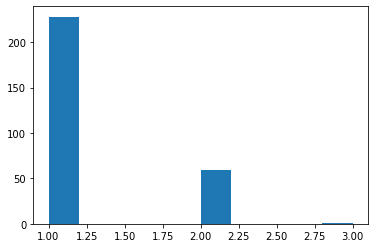

In [1965]:
plt.hist([np.round(x[0]) for x in predictions]);

## Trying out different regression models

In [1782]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score

In [1824]:
true_values = np.round(target_scaler.inverse_transform(test_data[["team_goals"]]))

##### 1. Random forest regressor

In [1783]:
train_data.drop(np.where(train_data["team_goals"]>3)[0], inplace=True)
test_data.drop(np.where(test_data["team_goals"]>3)[0], inplace=True)

train_data.drop(columns=["fixture_id" ,'opponent_goals'], inplace=True)
test_data.drop(columns=["fixture_id" ,'opponent_goals'], inplace=True)

In [1784]:
from sklearn.ensemble import RandomForestRegressor

In [1785]:
model_rf = RandomForestRegressor()

cross_val_score(model_rf, train_data.drop(columns=['team_goals']), train_data.team_goals, scoring="accuracy", cv = 4)

In [1786]:
model_rf.fit(train_data.drop(columns=["team_goals"]), train_data["team_goals"])

RandomForestRegressor()

In [1798]:
preds_rf = model_rf.predict(test_data.drop("team_goals", axis=1))

In [1799]:
mean_squared_error(test_data.team_goals, preds_rf)

0.03374082341269841

In [1804]:
preds_rf = np.round(target_scaler.inverse_transform(np.array(preds_rf.reshape(-1,1))))

In [1805]:
preds_rf

array([[2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [0.],
       [1.],
       [2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],

0.3125

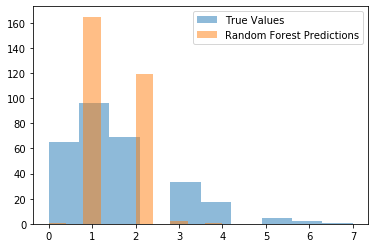

In [1810]:
plt.hist(true_values, alpha = 0.5, label="True Values");
plt.hist(preds_rf, alpha = 0.5, label="Random Forest Predictions");
plt.legend();

In [1812]:
np.bincount([int(x) for x in preds_rf])


array([  1, 165, 119,   2,   1])

In [1828]:
np.bincount([int(x) for x in true_values])


array([65, 96, 69, 33, 17,  5,  2,  1])

In [1829]:
model_sv = sklearn.svm.SVR()

In [1830]:
model_sv.fit(train_data.drop(columns=["team_goals"]), train_data["team_goals"])

SVR()

In [1831]:
preds_sv = model_sv.predict(test_data.drop("team_goals", axis=1))

In [1832]:
mean_squared_error(test_data.team_goals, preds_sv)

0.034790671227336124

In [1833]:
preds_sv = np.round(target_scaler.inverse_transform(np.array(preds_sv.reshape(-1,1))))

In [1835]:
accuracy_score(true_values, preds_sv)

0.3263888888888889

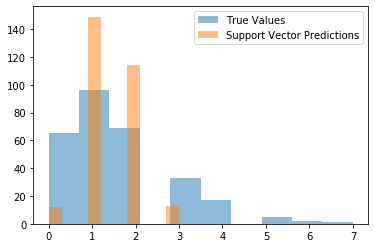

In [1836]:
plt.hist(true_values, alpha = 0.5, label="True Values");
plt.hist(preds_sv, alpha = 0.5, label="Support Vector Predictions");
plt.legend();

In [1837]:
np.bincount([int(x) for x in preds_sv])


array([ 12, 149, 114,  13])

In [1838]:
np.bincount([int(x) for x in true_values])


array([65, 96, 69, 33, 17,  5,  2,  1])

<br>

In [1842]:
from sklearn.kernel_ridge import KernelRidge

In [1843]:
model_krr = KernelRidge(alpha=0.2, kernel='polynomial', degree=1, coef0=1)


In [1844]:
model_krr.fit(train_data.drop("team_goals", axis=1), train_data["team_goals"])

KernelRidge(alpha=0.2, degree=1, kernel='polynomial')

In [1845]:
preds_krr = model_krr.predict(test_data.drop("team_goals",axis=1))

In [1525]:
mean_squared_error(test_data.team_goals, preds_krr)

1.015209125475285

In [1846]:
preds_krr =  np.round(target_scaler.inverse_transform(np.array(preds_krr.reshape(-1,1))))

In [1848]:
accuracy_score(true_values, preds_krr)

0.3402777777777778

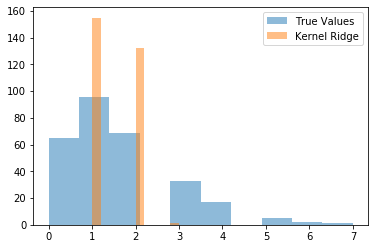

In [1850]:
plt.hist(true_values, alpha = 0.5, label="True Values");
plt.hist(preds_krr, alpha = 0.5, label="Kernel Ridge");
plt.legend();

In [1851]:
np.bincount([int(x) for x in preds_lr])


array([ 51, 137,  68,   7])

In [1853]:
np.bincount([int(x) for x in true_values])


array([65, 96, 69, 33, 17,  5,  2,  1])

<br>

In [1854]:
from sklearn.linear_model import ElasticNet

In [1855]:
model_en = ElasticNet(alpha=0.005, l1_ratio=.86)

In [1857]:
model_en.fit(train_data.drop("team_goals",axis=1), train_data["team_goals"])

ElasticNet(alpha=0.005, l1_ratio=0.86)

In [1859]:
preds_en = model_en.predict(test_data.drop("team_goals", axis=1))

In [1861]:
mean_squared_error(test_data.team_goals, preds_en)

0.03451650685278424

In [1862]:
preds_en = np.round(target_scaler.inverse_transform(np.array(preds_en.reshape(-1,1))))

In [1863]:
accuracy_score(true_values, preds_en)

0.3125

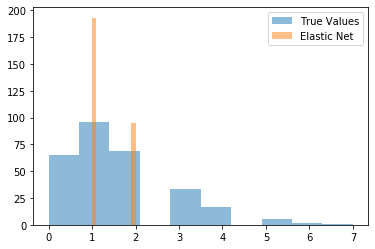

In [1866]:
plt.hist(true_values, alpha = 0.5, label="True Values");
plt.hist(preds_en, alpha = 0.5, label="Elastic Net");
plt.legend();

In [1867]:
np.bincount([int(x) for x in preds_en])


array([  0, 193,  95])

In [1870]:
np.bincount([int(x) for x in true_values])


array([65, 96, 69, 33, 17,  5,  2,  1])

In [1871]:
from sklearn.ensemble import GradientBoostingRegressor

In [1872]:
model_gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=16, min_samples_split=30, 
                                   loss='huber', random_state =5)

In [1873]:
model_gb.fit(train_data.drop("team_goals", axis=1), train_data["team_goals"])

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=16,
                          min_samples_split=30, n_estimators=1000,
                          random_state=5)

In [1874]:
preds_gb = model_gb.predict(test_data.drop("team_goals", axis=1))

In [1875]:
mean_squared_error(test_data.team_goals, preds_gb)

0.03295973428323187

In [1876]:
preds_gb = np.round(target_scaler.inverse_transform(np.array(preds_gb.reshape(-1,1))))

In [1878]:
accuracy_score(true_values, preds_gb)

0.34375

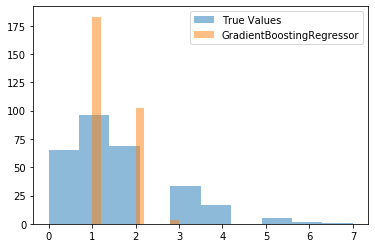

In [1880]:
plt.hist(true_values, alpha = 0.5, label="True Values");
plt.hist(preds_gb, alpha = 0.5, label="GradientBoostingRegressor");
plt.legend();

In [1881]:
np.bincount([int(x) for x in preds_gb])


array([  0, 183, 102,   3])

In [1882]:
np.bincount([int(x) for x in true_values])


array([65, 96, 69, 33, 17,  5,  2,  1])

<br>

In [1883]:
import xgboost as xgb

In [1895]:
model_xgb = xgb.XGBRegressor(base_score = 0.5, colsample_bytree=0.466, gamma=0.01, 
                             learning_rate=0.01, max_depth=3, 
                             min_child_weight=5, n_estimators=980,
                             reg_alpha=0.5, reg_lambda=0.05,
                             subsample=0.72, random_state =5, nthread = 2)

In [1886]:
model_xgb = xgb.XGBRegressor()

In [1896]:
model_xgb.fit(train_data.drop("team_goals", axis=1), train_data["team_goals"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.466, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=980, n_jobs=2, nthread=2, num_parallel_tree=1,
             random_state=5, reg_alpha=0.5, reg_lambda=0.05, scale_pos_weight=1,
             subsample=0.72, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [1897]:
preds_xgb = model_xgb.predict(test_data.drop("team_goals", axis=1))

In [1898]:
mean_squared_error(test_data.team_goals, preds_xgb)

0.032336868833962265

In [1899]:
preds_xgb = np.round(target_scaler.inverse_transform(np.array(preds_xgb.reshape(-1,1))))

In [1900]:
accuracy_score(true_values, preds_xgb)

0.3298611111111111

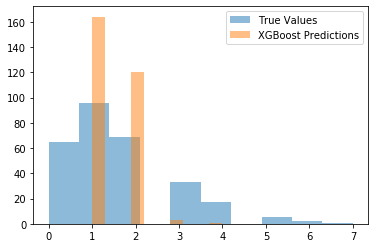

In [1901]:
plt.hist(true_values, alpha = 0.5, label="True Values");
plt.hist(preds_xgb, alpha = 0.5, label="XGBoost Predictions");
plt.legend();